# Thesis Outcomes - 1000 mean

In this notebook I will analyse the data when i'm trying to calculate the mean for 1000 vector of 8192 elements each.


## Setup

In [2]:
# Imports
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Function to extract files from folder
def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
            files = glob.glob(os.path.join(root, '*.csv'))
            for f in files:
                    all_files.append(os.path.abspath(f))
    return all_files

In [11]:
# Get file names
outcomes_CSV = get_files("../timeCSVs")

# Import csv as a Dataframe
mean_DF = pd.read_csv(outcomes_CSV[0])


In [9]:
# Auxiliary Functions

def compare_two_types_by_percentage(column1, column2, df):
    return ((df.loc[df['Type'] == column2]['Average'].values[0] - df.loc[df['Type'] == column1]['Average'].values[0] )/ df.loc[df['Type'] == column2]['Average'].values[0]) * 100

def create_df_for_type(type, setup_averages, encryption_averages, homomorphic_averages):
    df = pd.DataFrame(columns=['Time'], index=['Setup', 'Encryption', 'Homomorphic'])

    df.loc['Setup'] = float(format(setup_averages[setup_averages['Type'] == type]['Average'].values[0], ".2f"))
    df.loc['Encryption'] = float(format(encryption_averages[encryption_averages['Type'] == type]['Average'].values[0], ".2f"))
    df.loc['Homomorphic'] = float(format(homomorphic_averages[homomorphic_averages['Type'] == type]['Average'].values[0], ".2f"))

    return df

## Mean

For the mean I have 4 types of implementation.

The first, and the most naive, is the one where each value is encrypted into a single ciphertext. 

The second method is where we encrypt only one ciphertext and calculate the total sum by doing n rotations.

The third method is where we encrypt only one ciphertext and calculate the total sum by doing log2(n) rotations.

The forth method is only applicable to Coefficient Packing because it uses a pre-processing technique that only works with these type of packing.

In [12]:
mean_DF['type'].unique()

array(['opt-rot-slot', 'opt-coef-rot', 'pre-proc-coef',
       'no-pre-proc-coef', 'pre-comp-coef'], dtype=object)

In [22]:
### Create DF for each type of implementation
opt_coef_rot_DF = mean_DF[mean_DF['type'] == "opt-coef-rot"]
opt_slot_rot_DF = mean_DF[mean_DF['type'] == "opt-rot-slot"]
pre_proc_coef_DF = mean_DF[mean_DF['type'] == "pre-proc-coef"]
no_pre_proc_coef_DF = mean_DF[mean_DF['type'] == "no-pre-proc-coef"]
pre_comp_coef_DF = mean_DF[mean_DF['type'] =='pre-comp-coef']

implementation_dfs = {'opt-rot-slot': opt_slot_rot_DF, 
                      'opt-coef-rot': opt_coef_rot_DF, 'pre-proc-coef': pre_proc_coef_DF, 
                      'no-pre-proc-coef': no_pre_proc_coef_DF, 'pre-comp-coef': pre_comp_coef_DF}

### Total Time Comparison

In [23]:
total_time_averages = pd.DataFrame({'Type': pd.Series(dtype='str'),
                                    'Average': pd.Series(dtype='float')})

for name, df in implementation_dfs.items():
    total_time_averages.loc[len(total_time_averages)] = {'Type': name, 'Average': df[' total'].mean()}

[Text(0, 0, '9095.26'),
 Text(0, 0, '14734.6'),
 Text(0, 0, '15085.7'),
 Text(0, 0, '14614.3'),
 Text(0, 0, '15127.7')]

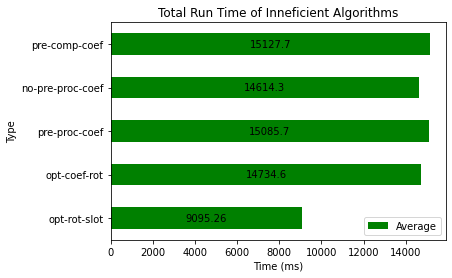

In [24]:
ax = total_time_averages.plot.barh(x='Type', ylabel='Time (ms)', color='green', title='Total Run Time of Inneficient Algorithms')
ax.set_xlabel('Time (ms)')
ax.bar_label(ax.containers[0], label_type='center')

In [33]:
# Compare Opt Rot Slot vs Simple Coef
opt_rot_slot_vs_coef = format(compare_two_types_by_percentage('opt-rot-slot', "opt-coef-rot", total_time_averages),
                             ".2f")

# Compare Opt Rot Slot vs Pre processed coef
opt_rot_slot_vs_pre_proc_coef = format(compare_two_types_by_percentage('opt-rot-slot', "pre-proc-coef", total_time_averages),
                             ".2f")

# Compare Opt Rot Slot vs no Pre process coef
opt_rot_slot_vs_no_pre_proc_coef = format(compare_two_types_by_percentage('opt-rot-slot', "no-pre-proc-coef", total_time_averages),
                             ".2f")

# Compare Opt Rot Slot vs Pre computed coef
opt_rot_slot_vs_pre_comp_coef = format(compare_two_types_by_percentage('opt-rot-slot', "pre-comp-coef", total_time_averages),
                             ".2f")

total_time_mean = (float(opt_rot_slot_vs_coef) + float(opt_rot_slot_vs_pre_proc_coef) +
                   float(opt_rot_slot_vs_no_pre_proc_coef) + float(opt_rot_slot_vs_pre_comp_coef)) / 4

### Time per phase

I divided the algorithms in 5 phases: setup, encryption, homomorphic operations, decryption, plaintext operations.

The Setup Time includes the time it takes to generate all the parameters needed, generate the rotation keys needed, and the time it takes to pre process the values.

The Encryption is the time it takes to encrypt all the needed ciphertexts.

The Homomorphic Operation is the time it takes to execute all the homomorphic operations needed.

The Decryption is the time it takes to decrypt all the ciphertexts. Since we end up only decrypting one ciphertext, I don't use time for comparison.

The Plaintext Operation is the time it takes to execute all the operations over plaintexts. This is also not gonna be used because i would only do, at most, 1 plaintext operation and since it is plaintext it is the always the same value (it is not influenced by homomorphic scheme or packing type)

In [26]:
### Create a DataFrame for each phase with the average of each type of algorithm

# Setup
setup_averages = pd.DataFrame({'Type': pd.Series(dtype='str'),
                                    'Average': pd.Series(dtype='float')})

for name, df in implementation_dfs.items():
    setup_averages.loc[len(setup_averages)] = {'Type': name, 'Average': df[' setup'].mean()}

# Encryption
encryption_averages = pd.DataFrame({'Type': pd.Series(dtype='str'),
                                    'Average': pd.Series(dtype='float')})

for name, df in implementation_dfs.items():
    encryption_averages.loc[len(encryption_averages)] = {'Type': name, 'Average': df[' encryption'].mean()}

# Homomorphic
homomorphic_averages = pd.DataFrame({'Type': pd.Series(dtype='str'),
                                    'Average': pd.Series(dtype='float')})

for name, df in implementation_dfs.items():
    homomorphic_averages.loc[len(homomorphic_averages)] = {'Type': name, 'Average': df[' homomorphic'].mean()}

In [34]:
# Setup Operations Comparison
# Compare Opt Rot Coef vs Opt Rot Slot
setup_opt_rot_coef_vs_opt_rot_slot = format(compare_two_types_by_percentage("opt-coef-rot", 'opt-rot-slot', setup_averages),
                             ".2f")

# Compare pre computed coef vs Pre processed coef
setup_pre_comp_coef_vs_pre_proc_coef = format(compare_two_types_by_percentage('pre-comp-coef', "pre-proc-coef", setup_averages),
                             ".2f")

# Compare no Pre process coef vs Opt Rot Slot: 
setup_no_pre_proc_coef_vs_opt_rot_slot = format(compare_two_types_by_percentage("no-pre-proc-coef", 'opt-rot-slot', setup_averages),
                             ".2f")

# Compare Opt Rot Slot vs Pre process coef
setup_opt_rot_slot_vs_pre_comp_coef = format(compare_two_types_by_percentage('opt-rot-slot', "pre-proc-coef", setup_averages),
                             ".2f")

# Encryption Operations Comparison
# Compare Opt Rot Slot vs Opt Rot Coef
encryption_opt_rot_slot_vs_opt_rot_coef = format(compare_two_types_by_percentage('opt-rot-slot', "opt-coef-rot", encryption_averages),
                             ".2f")

# Compare Opt Rot Slot vs Pre processed coef
encryption_opt_rot_slot_vs_pre_proc_coef = format(compare_two_types_by_percentage('opt-rot-slot', "pre-proc-coef", encryption_averages),
                             ".2f")

# Compare Opt Rot Slot vs no Pre process coef
encryption_opt_rot_slot_vs_no_pre_proc_coef = format(compare_two_types_by_percentage('opt-rot-slot', "no-pre-proc-coef", encryption_averages),
                             ".2f")

# Compare Opt Rot Slot vs Pre computed coef
encryption_opt_rot_slot_vs_pre_comp_coef = format(compare_two_types_by_percentage('opt-rot-slot', "pre-comp-coef", encryption_averages),
                             ".2f")

encryption_mean = (float(encryption_opt_rot_slot_vs_opt_rot_coef) + float(encryption_opt_rot_slot_vs_pre_proc_coef) +
                   float(encryption_opt_rot_slot_vs_no_pre_proc_coef) + float(encryption_opt_rot_slot_vs_pre_comp_coef)) / 4

# Homomorphic Operations Comparison
# Compare Opt Coef Slot vs Opt Rot Slot
homomorphic_opt_rot_coef_vs_opt_rot_slot = format(compare_two_types_by_percentage("opt-coef-rot", 'opt-rot-slot', homomorphic_averages),
                             ".2f")

# Compare Pre processed coef vs Opt Rot Slot
homomorphic_pre_proc_coef_vs_opt_rot_slot = format(compare_two_types_by_percentage("pre-proc-coef", 'opt-rot-slot', homomorphic_averages),
                             ".2f")

# Compare no Pre process coef vs Opt Rot Slot
homomorphic_no_pre_proc_coef_vs_opt_rot_slot = format(compare_two_types_by_percentage("no-pre-proc-coef", 'opt-rot-slot', homomorphic_averages),
                             ".2f")

# Compare Pre computed coef vs Opt Rot Slot
homomorphic_pre_comp_coef_vs_opt_rot_slot = format(compare_two_types_by_percentage("pre-comp-coef", 'opt-rot-slot', homomorphic_averages),
                             ".2f")

homomorphic_mean = (float(homomorphic_opt_rot_coef_vs_opt_rot_slot) + float(homomorphic_pre_proc_coef_vs_opt_rot_slot)
                     + float(homomorphic_no_pre_proc_coef_vs_opt_rot_slot) + float(homomorphic_pre_comp_coef_vs_opt_rot_slot)) / 4

[Text(50, 0, '417.15'),
 Text(50, 0, '381.64'),
 Text(50, 0, '372.786'),
 Text(50, 0, '373.524'),
 Text(50, 0, '390.274')]

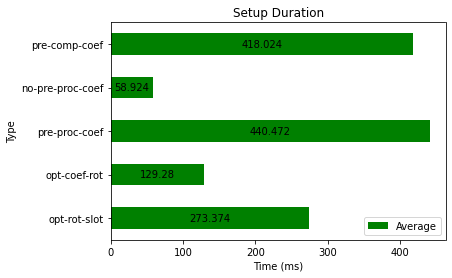

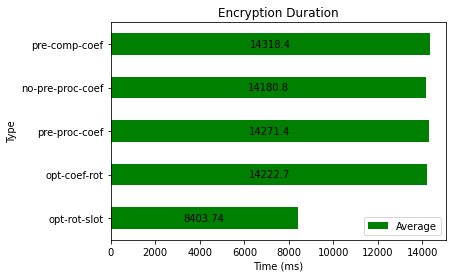

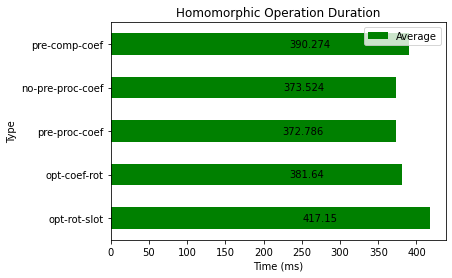

In [30]:
### Plot a graph for each phase

# Setup
ax = setup_averages.plot.barh(x='Type', color='green', title='Setup Duration')
ax.set_xlabel('Time (ms)')
ax.bar_label(ax.containers[0], label_type='center')

# Encryption
ax = encryption_averages.plot.barh(x='Type', color='green', title='Encryption Duration')
ax.set_xlabel('Time (ms)')
ax.bar_label(ax.containers[0], label_type='center')

# Homomorphic
# Needs two graphs because the values ara in a huge range
ax = homomorphic_averages.plot.barh(x='Type', ylabel='Time (ms)', color='green', title='Homomorphic Operation Duration')
ax.set_xlabel('Time (ms)')
ax.bar_label(ax.containers[0], label_type='center', padding=50)

In [38]:
print("Total Time:")
print("Opt Rot Slot vs Opt Rot Coef: " + opt_rot_slot_vs_coef + "%")
print("Opt Rot Slot vs Pre processed coef: " + opt_rot_slot_vs_pre_proc_coef + "%")
print("Opt Rot Slot vs no Pre process coef: " + opt_rot_slot_vs_no_pre_proc_coef + "%")
print("Opt Rot Slot vs Pre computed coef: " + opt_rot_slot_vs_pre_comp_coef + "%")
print("Average Opt Rot: " + str(total_time_mean) + "%")

print("\nSetup:")
print("Opt Rot Coef vs Opt Rot Slot: " + setup_opt_rot_coef_vs_opt_rot_slot + "%")
print("pre computed coef vs Pre processed coef: " + setup_pre_comp_coef_vs_pre_proc_coef + "%")
print("no Pre process coef vs Opt Rot Slot: " + setup_no_pre_proc_coef_vs_opt_rot_slot + "%")
print("Opt Rot Slot vs Pre process coef: " + setup_opt_rot_slot_vs_pre_comp_coef + "%")

print("\nEncryption Operations:")
print("Opt Rot Slot vs Opt Rot Coef: " + encryption_opt_rot_slot_vs_opt_rot_coef + "%")
print("Opt Rot Slot vs Pre processed coef: " + encryption_opt_rot_slot_vs_pre_proc_coef + "%")
print("Opt Rot Slot vs no Pre process coef: " + encryption_opt_rot_slot_vs_no_pre_proc_coef + "%")
print("Opt Rot Slot vs Pre computed coef:" + encryption_opt_rot_slot_vs_pre_comp_coef + "%")
print("Average Opt Rot: " + str(encryption_mean) + "%")

print("\nHomomorphic Operations:")
print("Opt Coef Slot vs Opt Rot Slot: " + homomorphic_opt_rot_coef_vs_opt_rot_slot + "%")
print("Pre processed coef vs Opt Rot Slot: " + homomorphic_pre_proc_coef_vs_opt_rot_slot + "%")
print("no Pre process coef vs Opt Rot Slot: " + homomorphic_no_pre_proc_coef_vs_opt_rot_slot + "%")
print("Pre computed coef vs Opt Rot Slot:" + homomorphic_pre_comp_coef_vs_opt_rot_slot + "%")
print("Average Coef: " + str(homomorphic_mean) + "%")



Total Time:
Opt Rot Slot vs Opt Rot Coef: 38.27%
Opt Rot Slot vs Pre processed coef: 39.71%
Opt Rot Slot vs no Pre process coef: 37.76%
Opt Rot Slot vs Pre computed coef: 39.88%
Average Opt Rot: 38.905%

Setup:
Opt Rot Coef vs Opt Rot Slot: 52.71%
pre computed coef vs Pre processed coef: 5.10%
no Pre process coef vs Opt Rot Slot: 78.45%
Opt Rot Slot vs Pre process coef: 37.94%

Encryption Operations:
Opt Rot Slot vs Opt Rot Coef: 40.91%
Opt Rot Slot vs Pre processed coef: 41.12%
Opt Rot Slot vs no Pre process coef: 40.74%
Opt Rot Slot vs Pre computed coef:41.31%
Average Opt Rot: 41.02%

Homomorphic Operations:
Opt Coef Slot vs Opt Rot Slot: 8.51%
Pre processed coef vs Opt Rot Slot: 10.64%
no Pre process coef vs Opt Rot Slot: 10.46%
Pre computed coef vs Opt Rot Slot:6.44%
Average Coef: 9.0125%


### Conclusion

With this experiment we can see the main drawback of coefficient packing, which is the time it takes to encrypt.

On average, slot packing is 41% faster in the encryption phase, when compared to coefficient packing implementation.

Although coefficient packing has faster operation, it is only 9% faster then the slot packing implementation. This makes sense as coefficient packing multiplications are way faster but the additions are pretty much the same. 

Since we use 1000 vectors, the homomorphic operations start by adding all those vector together, which takes most of the time.

In terms of setup, we can still see that the best implementation are the ones using coefficient algorithm. The fastest is the no pre processing, which makes sense since it only needs to generate the context parameters.

The second fastest is the optimized rotation using coefficient packing, it only has to generate the rotation plaintext (in addition to the parameters). This, as concluded in the original mean experiment, is 52% faster than the slot packing alternative.

In the setup phase we can also see that computing all the alphas only gives us a 5% speed up over computing them as we pre process the values.

We can also see the effect of having multiple vectos to pre process in the setup phase. While when we only had 1 vector of 8192 values, the pre processing was 79% faster than the optimized slot implementation. If we have 1000 vector that changes to the optimized slot implementation being, approximatly, 40% faster than both the pre computed and the pre processing variation.

All in all, the optimized slot rotation implementation was 38,9% faster than the coefficient implementations. This is mostly due to the advantage it has in the encryption phase.   